In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore','.*')

In [3]:
from IPython import display

In [4]:
import cStringIO as StringIO
from PIL import Image

In [5]:
import numpy as np
import matplotlib.pyplot as pl
from path import Path
import pandas as pd

In [6]:
import theano
import theano.tensor as T
import lasagne

Using gpu device 0: GeForce GTX 660 Ti


In [7]:
import pydnn
import pyimg
from pydnn.models.pseudofcn import PseudoFcn8_2

In [8]:
base_dir = Path('/home/aeroscout2/data/MSRC_ObjCategImageDatabase_v1/')

In [9]:
image_frames = sorted(base_dir.files('*_s.bmp'))

In [10]:
gt_image_frames = sorted(base_dir.files('*_GT.bmp'))

In [11]:
N = len(image_frames)
rng = np.random.RandomState(seed=28)
shuffle_idx = rng.permutation(N)
train_idx, test_idx = shuffle_idx[:-4], shuffle_idx[-4:]
image_frames

[Path(u'/home/aeroscout2/data/MSRC_ObjCategImageDatabase_v1/1_10_s.bmp'),
 Path(u'/home/aeroscout2/data/MSRC_ObjCategImageDatabase_v1/1_11_s.bmp'),
 Path(u'/home/aeroscout2/data/MSRC_ObjCategImageDatabase_v1/1_12_s.bmp'),
 Path(u'/home/aeroscout2/data/MSRC_ObjCategImageDatabase_v1/1_13_s.bmp'),
 Path(u'/home/aeroscout2/data/MSRC_ObjCategImageDatabase_v1/1_14_s.bmp'),
 Path(u'/home/aeroscout2/data/MSRC_ObjCategImageDatabase_v1/1_15_s.bmp'),
 Path(u'/home/aeroscout2/data/MSRC_ObjCategImageDatabase_v1/1_16_s.bmp'),
 Path(u'/home/aeroscout2/data/MSRC_ObjCategImageDatabase_v1/1_17_s.bmp'),
 Path(u'/home/aeroscout2/data/MSRC_ObjCategImageDatabase_v1/1_18_s.bmp'),
 Path(u'/home/aeroscout2/data/MSRC_ObjCategImageDatabase_v1/1_19_s.bmp'),
 Path(u'/home/aeroscout2/data/MSRC_ObjCategImageDatabase_v1/1_1_s.bmp'),
 Path(u'/home/aeroscout2/data/MSRC_ObjCategImageDatabase_v1/1_20_s.bmp'),
 Path(u'/home/aeroscout2/data/MSRC_ObjCategImageDatabase_v1/1_21_s.bmp'),
 Path(u'/home/aeroscout2/data/MSRC_ObjC

In [12]:
N_train = len(train_idx)
N_test = len(test_idx)

/usr/lib/pymodules/python2.7/matplotlib/image.py:1313: DeprecationWarning: tostring() is deprecated. Please call tobytes() instead.
  x_str = im.tostring('raw', im.mode)
/usr/lib/pymodules/python2.7/matplotlib/image.py:1313: DeprecationWarning: tostring() is deprecated. Please call tobytes() instead.
  x_str = im.tostring('raw', im.mode)


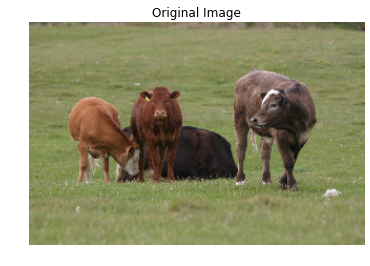

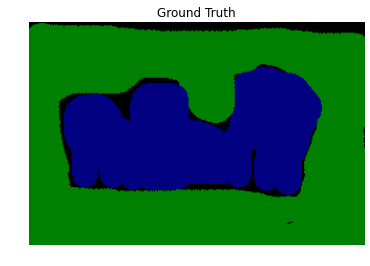

In [13]:
img = pl.imread(image_frames[4])
gt_img = pl.imread(gt_image_frames[4])
pl.imshow(img); pl.axis('off'); pl.title('Original Image'); pl.show();
pl.imshow(gt_img); pl.axis('off'); pl.title('Ground Truth'); pl.show()

In [14]:
labels_raw="""\
void	0	0	0	 
building	128	0	0	 
grass	0	128	0	 
tree	128	128	0	 
cow	0	0	128	 
horse	128	0	128	 
sheep	0	128	128	 
sky	128	128	128	 
mountain	64	0	0	 
aeroplane	192	0	0	 
water	64	128	0	 
face	192	128	0	 
car	64	0	128	 
bicycle	192	0	128	 
"""

In [15]:
label_df = pd.read_table(StringIO.StringIO(labels_raw), sep='\t', header=None, names=('name', 'r', 'g', 'b', 'drop'))
print 'Label_df_Table1: \n', label_df
label_df = label_df.drop('drop', axis=1)
print '\n Label_df_Table2: \n', label_df
label_df['label'] = np.arange(len(label_df))
print '\n Label_df_Table3: \n', label_df

Label_df_Table1: 
         name    r    g    b drop
0        void    0    0    0     
1    building  128    0    0     
2       grass    0  128    0     
3        tree  128  128    0     
4         cow    0    0  128     
5       horse  128    0  128     
6       sheep    0  128  128     
7         sky  128  128  128     
8    mountain   64    0    0     
9   aeroplane  192    0    0     
10      water   64  128    0     
11       face  192  128    0     
12        car   64    0  128     
13    bicycle  192    0  128     

[14 rows x 5 columns]

 Label_df_Table2: 
         name    r    g    b
0        void    0    0    0
1    building  128    0    0
2       grass    0  128    0
3        tree  128  128    0
4         cow    0    0  128
5       horse  128    0  128
6       sheep    0  128  128
7         sky  128  128  128
8    mountain   64    0    0
9   aeroplane  192    0    0
10      water   64  128    0
11       face  192  128    0
12        car   64    0  128
13    bicycle  192    0

In [16]:
html = ['<table>']
for ix,row in label_df.iterrows():
    html.append('<tr><td>%s</td><td style="background-color:rgb(%d,%d,%d);">&nbsp;&nbsp;</td></tr>'%(row['name'], row.r,row.g,row.b))    
html.append('</table>')
display.display_html('\n'.join(html), raw=True)

void,
building,
grass,
tree,
cow,
horse,
sheep,
sky,
mountain,
aeroplane,
water,


In [17]:
rgb_to_label = dict(zip(map(tuple, label_df[['r', 'g', 'b']].values), label_df['label'].values))
print rgb_to_label

{(64, 0, 128): 12, (128, 128, 128): 7, (192, 128, 0): 11, (192, 0, 0): 9, (64, 128, 0): 10, (0, 128, 128): 6, (128, 0, 0): 1, (0, 0, 128): 4, (64, 0, 0): 8, (128, 0, 128): 5, (192, 0, 128): 13, (128, 128, 0): 3, (0, 128, 0): 2, (0, 0, 0): 0}


In [18]:
label_to_rgb = dict([(v,np.asarray(k)) for (k,v) in rgb_to_label.iteritems()])
print label_to_rgb

{0: array([0, 0, 0]), 1: array([128,   0,   0]), 2: array([  0, 128,   0]), 3: array([128, 128,   0]), 4: array([  0,   0, 128]), 5: array([128,   0, 128]), 6: array([  0, 128, 128]), 7: array([128, 128, 128]), 8: array([64,  0,  0]), 9: array([192,   0,   0]), 10: array([ 64, 128,   0]), 11: array([192, 128,   0]), 12: array([ 64,   0, 128]), 13: array([192,   0, 128])}


In [19]:
remapper = pyimg.cyimg.RgbRemapper(label_to_rgb) #????? values stored after remapping

In [20]:
batch_size = 8
num_class = len(label_df)-1
model = PseudoFcn8_2(batch_size, num_class)


In [21]:
H, W = model.input_height, model.input_width # H=227, W = 227
h, w = model.l_out.get_output_shape()[2:]  # h=27, w=27
X_data = np.zeros((N, 3, H, W), dtype=np.float32)
y_data = np.zeros((N, 1, h, w), dtype=np.float32)

In [22]:
model.l_out.get_output_shape() # Shape of final output with batch_size=8


(8, 13, 27, 27)

In [23]:
img_jit = pydnn.preprocessing.ImageBatchJitterer(x_output_shape=(H,W), y_output_shape=(h,w))
#x_output_shape= (227,227)
#y_output_shape = (27,27)

In [24]:
for n in xrange(N):
    img = Image.open(image_frames[n])
    img = np.asarray(img.resize((W, H), Image.LINEAR)).copy() #??image.linear
    gt_img = Image.open(gt_image_frames[n])
    gt_img = np.asarray(gt_img.resize((w, h), Image.NEAREST)).copy() #?? image.nearest   
    X_data[n] = np.rollaxis(img, 2).astype(np.float32)  # shape is (240,3,227,227) 
    y_data[n,0] = pyimg.cyimg.rgb_image_to_label_image(gt_img, rgb_to_label).astype(np.float32) #shape is (240,1,27,27)

print 'X_data Shape:', X_data.shape
print 'y_data Shape:', y_data.shape
print img.dtype

X_data Shape: (240, 3, 227, 227)
y_data Shape: (240, 1, 27, 27)
uint8


In [25]:
mean_px = X_data[train_idx].mean((0, 2, 3), keepdims=True) #??

In [26]:
mean_px.shape, mean_px

((1, 3, 1, 1), array([[[[ 124.92555237]],
 
         [[ 125.05422211]],
 
         [[ 103.8286438 ]]]], dtype=float32))

In [27]:
X_data -= mean_px

In [28]:
X_data_j, y_data_j = img_jit.preprocess(X_data[train_idx], y_data[train_idx]) #?? preprocessing
print 'Shape of X_data_j :', X_data_j.shape
print 'Shape of y_data_j :', y_data_j.shape

Shape of X_data_j : (236, 3, 227, 227)
Shape of y_data_j : (236, 1, 27, 27)


In [29]:
X_shared = theano.shared(X_data_j) # Creating the theano shared variable
y_shared = theano.shared(y_data_j)

In [30]:
#Defining Theano varaibles
X_batch = model.X
y_batch = model.y1 
batch_index = T.iscalar('b_ix')
batch_slice = slice(batch_index*model.batch_size, (batch_index+1)*batch_size)


In [31]:
#Defining outputs 
out = model.l_out.get_output(X_batch) # ??(predicted output) // the FCN is called here
dout = model.l_out.get_output(X_batch, deterministic = True) #difference b/w both outputs


/home/aeroscout2/mavscout_semantic/src/pydnn/python/pydnn/layers/alexnet_layers.py:129: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer division.
  dnn.dnn_conv(img=input[:, :input_channels / 2, :, :],
/home/aeroscout2/mavscout_semantic/src/pydnn/python/pydnn/layers/alexnet_layers.py:135: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer division.
  conv_out1 = dnn.dnn_conv(img=input[:, input_channels / 2:, :, :],
/home/aeroscout2/mavscout_semantic/src/pydnn/python/pydnn/layers/alexnet_layers.py:129: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer division.
  dnn.dnn_conv(img=input[:, :input_channels / 2, :, :],
/home/aeroscout2/mavscout_semantic/src/pydnn/python/pydnn/layers/alexnet_layers.py:135: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer di

In [32]:
#Defining loss
loss = model.get_loss(out, y_batch) + 0.0005*model.get_l2_norm()

In [33]:
#Getting and updating all the paramters of model
all_params = model.get_params()
updates = lasagne.updates.momentum(loss, all_params, 0.0001, 0.9)
print 'All parameters of model:\n', all_params

All parameters of model:
[conv1.W, conv1.b, conv1_nin.W, conv1_nin.b, conv2.W0, conv2.W1, conv2.b0, conv2.b1, conv3.W, conv3.b, conv4.W0, conv4.W1, conv4.b0, conv4.b1, conv4_nin.W, conv4_nin.b, conv5.W0, conv5.W1, conv5.b0, conv5.b1, conv6.W, conv6.b, conv7.W, conv7.b, conv7_nin.W, conv7_nin.b, conv_out_nin.W, conv_out_nin.b]


In [34]:
pred_fn = theano.function([batch_index], model.get_prediction_image(dout), givens={X_batch: X_shared[batch_slice]})

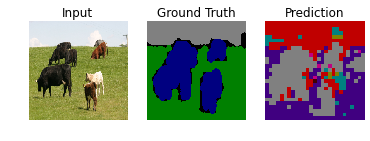

In [35]:
yi = 3
X_data_j, y_data_j = img_jit.preprocess(X_data[test_idx], y_data[test_idx], deterministic=True)
X_shared.set_value(X_data_j, borrow=True)
y_shared.set_value(y_data_j, borrow=True)
yhat_b = pred_fn(0) # output shape=(4,1,27,27)
yhat00 = remapper(yhat_b[yi,0]+1)  # why adding one ?
img = np.asarray(Image.open(image_frames[test_idx[yi]]).resize((256, 256)))
gt_img = np.asarray(Image.open(gt_image_frames[test_idx[yi]]).resize((256, 256)))
pl.subplot(1, 3, 1)
pl.imshow(img); pl.axis('off'); pl.title('Input'); 
pl.subplot(1, 3, 2)
pl.imshow(gt_img, interpolation='nearest'); pl.axis('off'); pl.title('Ground Truth')
pl.subplot(1, 3, 3)
pl.imshow(yhat00, interpolation='nearest'); pl.axis('off'); pl.title('Prediction')
pl.show()


In [36]:
#Batch training takes input batch index and gives loss as output, apply updates to loss
iter_train = theano.function([batch_index], loss, updates=updates, allow_input_downcast=True,
                            givens={X_batch: X_shared[batch_slice], y_batch: T.cast(y_shared[batch_slice], 'int32')})  

In [39]:
num_batches = N//batch_size
print num_batches
print yhat00.shape

30
(27, 27, 3)


In [122]:
for epoch in xrange(120):
    X_data_j, y_data_j = img_jit.preprocess(X_data, y_data)
    X_shared.set_value(X_data_j, borrow=True)
    y_shared.set_value(y_data_j, borrow=True)
    losses = []
    for bi in xrange(num_batches):
        losses.append(iter_train(bi))
        #print('loss: {}'.format(loss_value))
    print('epoch {}, average loss: {}'.format(epoch, np.mean(losses)))

epoch 0, average loss: 21.7084407806
epoch 1, average loss: 39.0110473633
epoch 2, average loss: 33.5528526306
epoch 3, average loss: 19.7107563019
epoch 4, average loss: 8.47321891785
epoch 5, average loss: 6.18045711517
epoch 6, average loss: 5.2921128273
epoch 7, average loss: 5.08133983612
epoch 8, average loss: 4.99768161774
epoch 9, average loss: 4.94342660904
epoch 10, average loss: 4.91459226608
epoch 11, average loss: 4.88054943085
epoch 12, average loss: 4.84269762039
epoch 13, average loss: 4.82003641129
epoch 14, average loss: 4.79138183594
epoch 15, average loss: 4.76616811752
epoch 16, average loss: 4.74088478088
epoch 17, average loss: 4.71999406815
epoch 18, average loss: 4.70548820496
epoch 19, average loss: 4.68743228912
epoch 20, average loss: 4.66960048676
epoch 21, average loss: 4.65568256378
epoch 22, average loss: 4.6333770752
epoch 23, average loss: 4.61745214462
epoch 24, average loss: 4.60383558273
epoch 25, average loss: 4.58967494965
epoch 26, average loss: 

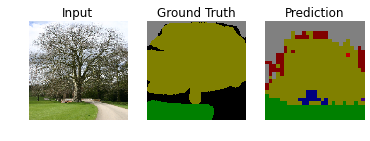

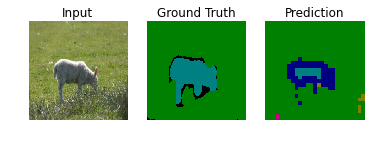

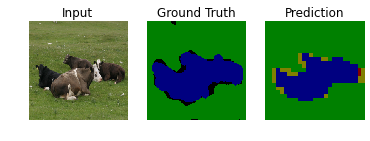

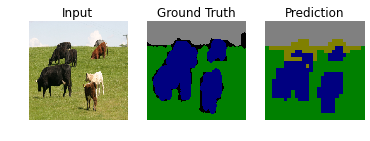

In [125]:
for yi in xrange(len(test_idx)):    
    X_data_j, y_data_j = img_jit.preprocess(X_data[test_idx], y_data[test_idx], deterministic=True)
    X_shared.set_value(X_data_j, borrow=True)
    y_shared.set_value(y_data_j, borrow=True)
    yhat_b = pred_fn(0) #testing is also batch type??
    yhat00 = remapper(yhat_b[yi,0]+1)
    img = np.asarray(Image.open(image_frames[test_idx[yi]]).resize((256, 256)))
    gt_img = np.asarray(Image.open(gt_image_frames[test_idx[yi]]).resize((256, 256)))
    pl.subplot(1, 3, 1)
    pl.imshow(img); pl.axis('off'); pl.title('Input'); 
    pl.subplot(1, 3, 2)
    pl.imshow(gt_img, interpolation='nearest'); pl.axis('off'); pl.title('Ground Truth')
    pl.subplot(1, 3, 3)
    pl.imshow(yhat00, interpolation='nearest'); pl.axis('off'); pl.title('Prediction')
    pl.show()

In [170]:
layers = lasagne.layers.helper.get_all_layers(model.l_out)

In [171]:
for layer in layers:
    print layer.name, layer.get_output_shape()

None (8, 3, 227, 227)
conv1 (8, 96, 27, 27)
conv1_nin (8, 512, 27, 27)
conv2 (8, 256, 13, 13)
conv3 (8, 384, 13, 13)
conv4 (8, 384, 13, 13)
conv4_nin (8, 512, 13, 13)
None (8, 512, 13, 13)
conv5 (8, 256, 6, 6)
conv6 (8, 4096, 5, 5)
conv7 (8, 4096, 5, 5)
None (8, 4096, 5, 5)
conv7_nin (8, 512, 5, 5)
conv7_nin_up (8, 512, 10, 10)
None (8, 512, 14, 14)
None (8, 512, 13, 13)
fcn16 (8, 512, 13, 13)
fcn16_up (8, 512, 26, 26)
None (8, 512, 28, 28)
None (8, 512, 27, 27)
None (8, 512, 27, 27)
None (8, 512, 27, 27)
conv_out_nin (8, 13, 27, 27)
